### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

### Load data

In [2]:
data = pd.read_excel('Data/Online Retail.xlsx')

In [3]:
# remove records without customer ID 

data = data[data.CustomerID.isnull() == False]

### Use 30% of the data for cohort analysis

In [4]:
# randomly sample 30%
sample = data.sample(frac=0.3)

### Data exploration

In [5]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 63247 to 253945
Data columns (total 8 columns):
InvoiceNo      122049 non-null object
StockCode      122049 non-null object
Description    122049 non-null object
Quantity       122049 non-null int64
InvoiceDate    122049 non-null datetime64[ns]
UnitPrice      122049 non-null float64
CustomerID     122049 non-null float64
Country        122049 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 8.4+ MB


In [6]:
sample.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
63247,541552,21975,PACK OF 60 DINOSAUR CAKE CASES,1,2011-01-19 11:15:00,0.55,15039.0,United Kingdom
397984,571216,20992,JAZZ HEARTS PURSE NOTEBOOK,1,2011-10-14 13:06:00,0.39,16081.0,United Kingdom
340526,566669,22114,HOT WATER BOTTLE TEA AND SYMPATHY,4,2011-09-14 11:36:00,3.95,18065.0,United Kingdom
87764,543731,84212,"ASSORTED FLOWER COLOUR ""LEIS""",24,2011-02-11 11:57:00,0.65,17677.0,United Kingdom
368870,569000,22047,EMPIRE GIFT WRAP,25,2011-09-29 17:36:00,0.42,17015.0,United Kingdom


In [7]:
sample.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
870,536477,21137,BLACK RECORD COVER FRAME,480,2010-12-01 12:27:00,3.39,16210.0,United Kingdom
166156,550899,84997C,CHILDRENS CUTLERY POLKADOT BLUE,4,2011-04-21 12:07:00,4.15,13505.0,Switzerland
289528,562269,20726,LUNCH BAG WOODLAND,2,2011-08-03 16:35:00,1.65,14056.0,United Kingdom
536867,581221,23213,STAR WREATH DECORATION WITH BELL,36,2011-12-08 09:40:00,1.25,17856.0,United Kingdom
253945,559202,20723,STRAWBERRY CHARLOTTE BAG,10,2011-07-07 10:40:00,0.85,13583.0,United Kingdom


### Data preprocessing

In [8]:
# create a new column to store total amount 
sample['total'] = sample['Quantity']  * sample['UnitPrice']

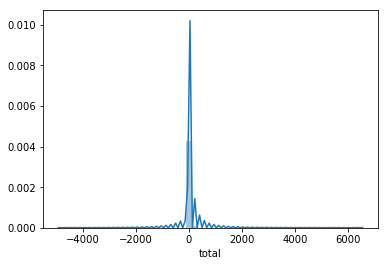

In [9]:
# check distribution of total
sns.distplot(sample['total'])

In [10]:
sample.describe()

,Quantity,UnitPrice,CustomerID,total
count,122049.000000,122049.000000,122049.000000,122049.000000
mean,12.035281,3.340847,15290.338528,20.648179
std,43.429183,26.088035,1714.157710,81.357842
min,-2000.000000,0.000000,12347.000000,-4921.500000
25%,2.000000,1.250000,13946.000000,4.200000
50%,5.000000,1.950000,15159.000000,11.250000
75%,12.000000,3.750000,16794.000000,19.500000
max,3114.000000,4287.630000,18287.000000,6539.400000


In [11]:
print ('Total Number of Records: ', len(sample))
print ('Total Number of Records with Negative Sales: ', len(sample[sample['total'] < 0]))
print ('Proportion of Records with Negative Sales: ', round(len(sample[sample['total'] < 0])/ len(sample), 2))

Total Number of Records:  122049
Total Number of Records with Negative Sales:  2614
Proportion of Records with Negative Sales:  0.02


In [12]:
# function to get invoice date
def get_day(x):
    return dt.datetime(x.year, x.month, x.day)

# create a new column to store invoice date
sample['InvoiceDay'] = sample['InvoiceDate'].apply(get_day)

In [13]:
# find the latest transaction day in the dataset
# assume the analysis is conducted a day after the latest transaction day
# add 1 more day to it to calculate recency

latest_day = sample['InvoiceDay'].max() + dt.timedelta(1)

### Calculate RFM

In [14]:
# calculate recency, monetary, frequency
rfm = sample.groupby('CustomerID').agg({
    'InvoiceDay': lambda x: (latest_day - x.max()).days,
    'InvoiceNo': 'count',
    'total': 'sum'
})

In [15]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [16]:
# seperate data into 5 bins. assign rfm labels based on bins 


# smaller recency --> higher label 
r_labels = range(5, 0, -1)
r_groups = pd.qcut(rfm['Recency'], q = 5, labels = r_labels)

# larger frequency --> higher label 
f_labels = range(1, 6, 1)
f_groups = pd.qcut(rfm['Frequency'], q = 5, labels = f_labels)

# larger monetary total --> higher label 
m_labels = range(1, 6, 1)
m_groups = pd.qcut(rfm['Monetary'], q = 5, labels = m_labels)


In [17]:
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [18]:
# concat R, F, M together
rfm['RFM_segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)

In [19]:
# assign segmentation 
'''
create a function to segment customers based on rfm segmentation 

reference
1. https://www.putler.com/rfm-analysis/
2. https://www.optimove.com/learning-center/rfm-segmentation

'''
def segmentation(x):
    if x[0] == '5' and x[1] == '5' and x[2] == '5':
        return 'Best Customers'
    elif x[0] == '5' and x[1] == '1' and x[2] in ['4', '5']:
        return 'High-Spending New Customers'
    elif x[0] == '5' and x[1] == '5' and x[2] in ['1', '2']: 
        return 'Low-Spending Active Loyal Customers'
    elif x[0] == '5' and x[1] == '5' and x[2] == '3': 
        return 'Average-Spending Active Loyal Customers'
    elif x[0] == '1' and x[1] in ['4', '5'] and x[2] in ['4', '5']: 
        return 'Can’t Lose Them'
    elif x[0] == '1' and x[1] == '1' and x[2] == '1':
        return 'Lost Low-Spending Customers'
    elif x[0] == '2' and x[1] in ['4', '5'] and x[2] in ['4', '5']: 
        return 'At Risk'
    elif x[0] in ['2', '3'] and x[1] in ['2', '3'] and x[2] in ['2', '3']: 
        return 'Customers Needing Attention'
    elif x[0] in ['1', '2'] and x[1] in ['1', '2'] and x[2] in ['1', '2']: 
        return 'Hibernating'

In [20]:
rfm['customer_segmentation'] = rfm['RFM_segment'].apply(segmentation)

In [21]:
rfm['customer_segmentation'].value_counts()

Customers Needing Attention                518
Hibernating                                515
Best Customers                             308
Lost Low-Spending Customers                249
At Risk                                    146
Can’t Lose Them                             44
Average-Spending Active Loyal Customers     20
High-Spending New Customers                  2
Low-Spending Active Loyal Customers          2
Name: customer_segmentation, dtype: int64

### KMeans Clustering 

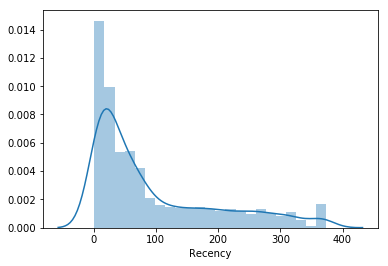

In [22]:
# check distribution and skewness
sns.distplot(rfm.Recency)

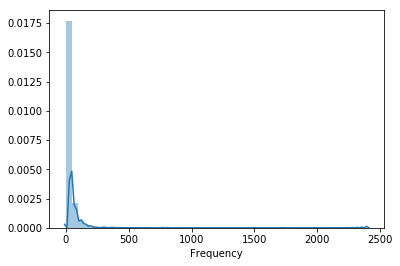

In [23]:
sns.distplot(rfm.Frequency)

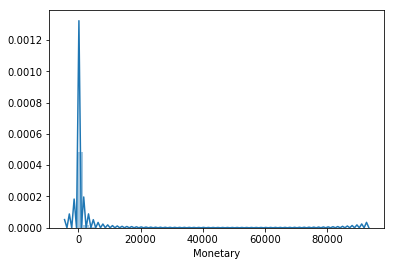

In [24]:
# there are negative values
sns.distplot(rfm.Monetary)

In [25]:
# transform data : 1. before log transformation, change negative values or 0 into 1 

rfm['Monetary'] = rfm['Monetary'].apply(lambda x: 1 if x <= 0 else x)

# transform data : 2. log transformation 
import numpy as np 
rfm_transform = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

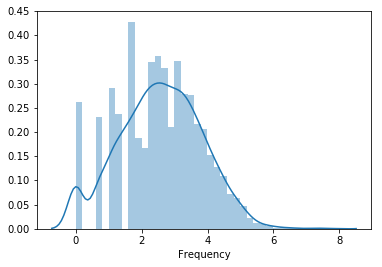

In [26]:
# check distribution

sns.distplot(rfm_transform.Frequency)

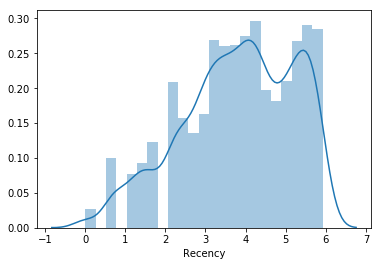

In [27]:
sns.distplot(rfm_transform.Recency)

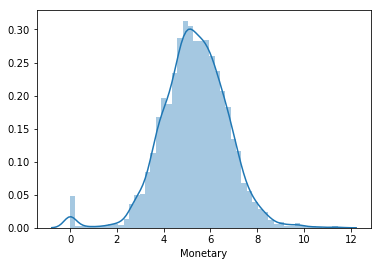

In [28]:
sns.distplot(rfm_transform.Monetary)

In [29]:
# import StandardScaler and KMeans for clustering

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [30]:
scaler = StandardScaler()
# standardise - rfm_transform has three different scales
rfm_scaled = scaler.fit_transform(rfm_transform)

# store standardised data in a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_transform.columns)

In [31]:
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,-1.947325,1.098254,1.203453
12348.0,1.226176,-0.213814,0.733418
12349.0,-0.622040,0.515466,0.527645
12350.0,1.386359,-0.498042,-0.320814
12352.0,-0.142926,0.296523,1.277446


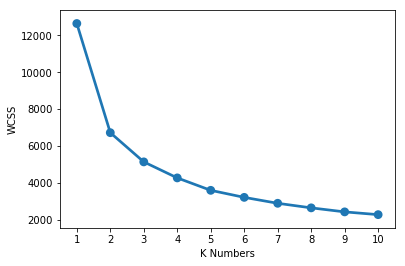

In [32]:
# find the optimal K that minimises within cluster sum of squares
# reference : https://towardsdatascience.com/who-is-your-golden-goose-cohort-analysis-50c9de5dbd31
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 150)
    kmeans.fit(rfm_scaled)
    wcss[k] = kmeans.inertia_
    
# plot the WCSS values to identify elbow
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [33]:
# cluster data into the optimal number of clusters : 3
cluster = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 150)
cluster.fit(rfm_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=150,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [34]:
# assign clusters
rfm['K_Cluster'] = cluster.labels_
rfm.K_Cluster.value_counts()

0    1849
2    1230
1    1134
Name: K_Cluster, dtype: int64

In [35]:
# find average numbers for each 
rfm.groupby('K_Cluster').agg({'Monetary': 'median', 'Frequency': 'median', 'Recency': 'median'})

,Monetary,Frequency,Recency
K_Cluster,,,
0,220.55,15,61
1,761.99,49,10
2,53.30,3,177


In [36]:
# compare clusters and customer segmentation
rfm.groupby('K_Cluster')['customer_segmentation'].value_counts()

K_Cluster  customer_segmentation                  
0          Customers Needing Attention                444
           At Risk                                    136
           Can’t Lose Them                             44
           Hibernating                                 17
           High-Spending New Customers                  1
1          Best Customers                             308
           Average-Spending Active Loyal Customers     20
           At Risk                                     10
           Low-Spending Active Loyal Customers          2
           High-Spending New Customers                  1
2          Hibernating                                498
           Lost Low-Spending Customers                249
           Customers Needing Attention                 74
Name: customer_segmentation, dtype: int64